In [80]:
import numpy as np
import pandas as pd
import random
import json
from collections import defaultdict

# Загрузка данных
flows = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

NUM_INTERSECTIONS = 3
GENE_SIZE = 4
TRAVEL_TIME = 30

In [81]:
pheromones = defaultdict(lambda: 1.0)  # феромон по умолчанию
EVAPORATION = 0.1
ALPHA = 1.0  # важность феромонов
BETA = 2.0   # важность эвристики
NUM_ANTS = 50
NUM_GENERATIONS = 100

In [82]:
def generate_ant_solution():
    solution = []
    lost = 2 * constraints['lost_time_sec_per_phase']
    for inter in range(NUM_INTERSECTIONS):
        c = random.randint(constraints['min_cycle_sec'], constraints['max_cycle_sec'])

        # Выбор зелёных фаз с эвристикой
        options = []
        for g1 in range(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost + 1):
            for g2 in range(constraints['min_green_sec'], c - g1 - lost + 1):
                if g1 + g2 + lost <= c:
                    heuristic = g1 + g2  # или более сложная эвристика
                    pher = pheromones[(inter, g1, g2)]
                    prob = (pher ** ALPHA) * (heuristic ** BETA)
                    options.append((g1, g2, prob))

        if not options:
            return None

        g1, g2 = random.choices(
            population=[(g1, g2) for g1, g2, _ in options],
            weights=[p for _, _, p in options],
            k=1
        )[0]

        offset = random.randint(0, c)
        solution.extend([c, g1, g2, offset])
    return solution

In [83]:
def fitness(ind):
    total_delay = 0.0
    lost = 2 * constraints['lost_time_sec_per_phase']

    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = ind[base:base+GENE_SIZE]

        # Проверка ограничений
        if not (constraints['min_cycle_sec'] <= cycle <= constraints['max_cycle_sec']):
            return (1e9,)
        if g_main < constraints['min_green_sec'] or g_sec < constraints['min_green_sec']:
            return (1e9,)
        if g_main < constraints['pedestrian_green_sec'] or g_sec < constraints['pedestrian_green_sec']:
            return (1e9,)
        if g_main + g_sec + lost > cycle:
            return (1e9,)
        if not (0 <= offset <= cycle):
            return (1e9,)

        # Задержка по всем потокам с приоритетом автобусов
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share

            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share

            total_delay += (cycle - eff_green) * flow * weight

    # Координация (зелёная волна) с умеренным штрафом
    # Зелёная волна — точный расчёт
    penalty = 0.0
    offset_prev = ind[3]  # offset первого перекрёстка
    for i in range(1, NUM_INTERSECTIONS):
        cycle_curr = ind[i * GENE_SIZE]
        offset_curr = ind[i * GENE_SIZE + 3]
        # Ожидаемое начало: смещение предыдущего + travel_time, но всегда в пределах текущего цикла
        expected = (offset_prev + TRAVEL_TIME) % cycle_curr
        diff = abs(offset_curr - expected)
        penalty += min(diff, cycle_curr - diff)
        offset_prev = offset_curr



    return (total_delay + 100* penalty,)

In [84]:
def evaluate(solution):
    if solution is None:
        return 1e9
    return fitness(solution)[0]

In [85]:
best_solution = None
best_score = float('inf')

for gen in range(NUM_GENERATIONS):
    ants = [generate_ant_solution() for _ in range(NUM_ANTS)]
    scores = [evaluate(a) for a in ants]

    for ant, score in zip(ants, scores):
        if score < best_score:
            best_score = score
            best_solution = ant

    # Обновление феромонов
    for inter in range(NUM_INTERSECTIONS):
        for g1 in range(constraints['min_green_sec'], 61):
            for g2 in range(constraints['min_green_sec'], 61):
                pheromones[(inter, g1, g2)] *= (1 - EVAPORATION)

    for ant, score in zip(ants, scores):
        if ant is None:
            continue
        for inter in range(NUM_INTERSECTIONS):
            idx = inter * GENE_SIZE
            _, g1, g2, _ = ant[idx:idx+GENE_SIZE]
            pheromones[(inter, g1, g2)] += 1.0 / (score + 1e-6)  # усиление

with open("best_solution.json", "w") as f:
    json.dump(best_solution, f)

In [86]:
print("\n=== Лучшее решение (ACO) ===")
for i in range(NUM_INTERSECTIONS):
    b = i * GENE_SIZE
    c, g1, g2, off = best_solution[b:b+GENE_SIZE]
    print(f"Перекрёсток {i+1}: Цикл={c}, главная={g1}, второстепенная={g2}, offset={off}")
print(f"Фитнес (задержка): {best_score:,.2f}")


=== Лучшее решение (ACO) ===
Перекрёсток 1: Цикл=80, главная=48, второстепенная=18, offset=3
Перекрёсток 2: Цикл=66, главная=37, второстепенная=16, offset=25
Перекрёсток 3: Цикл=60, главная=30, второстепенная=16, offset=57
Фитнес (задержка): 304,513.20


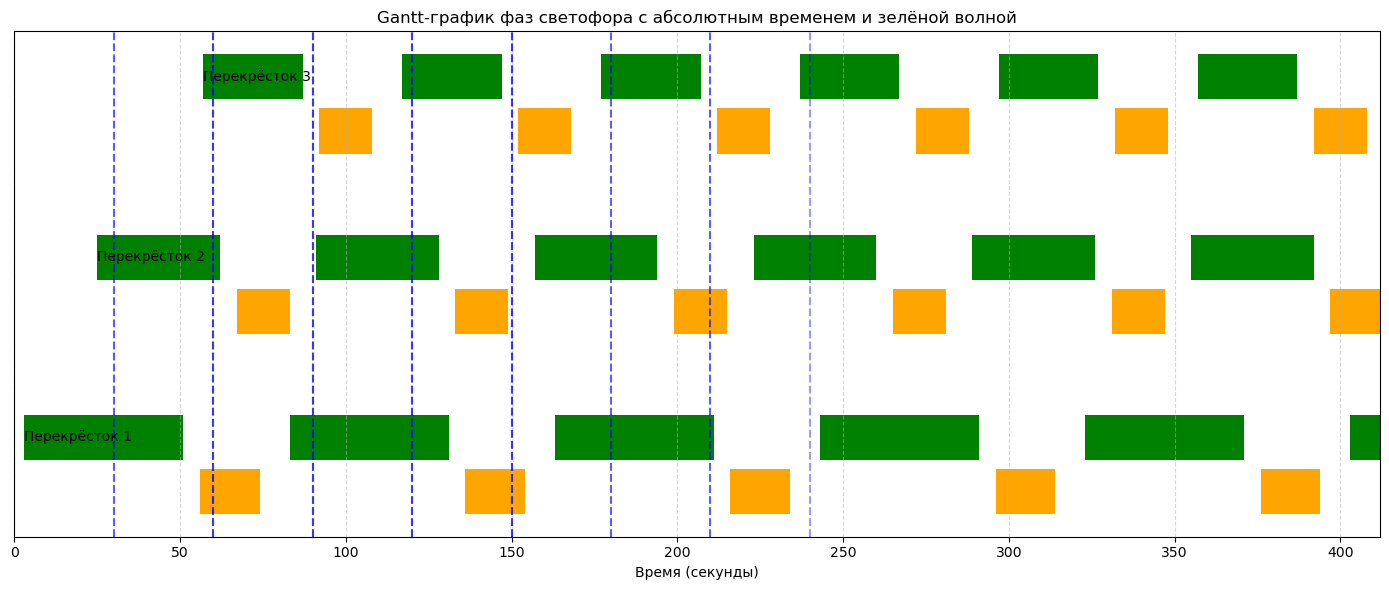

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

best_solution = [80, 48, 18, 3, 66, 37, 16, 25, 60, 30, 16, 57]
# === ПАРАМЕТРЫ ===
NUM_INTERSECTIONS = 3
GENE_SIZE = 4
TRAVEL_TIME = 30  # секунд между перекрёстками
constraints = {
    "lost_time_sec_per_phase": 5
}


# === ПРЕОБРАЗОВАНИЕ best_solution В signal_plan ===
def build_signal_plan(solution):
    signal_plan = {}
    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = solution[base:base+GENE_SIZE]
        signal_plan[i + 1] = {
            "cycle": int(cycle),
            "main": int(g_main),
            "sec": int(g_sec),
            "abs_offset": int(offset)
        }
    return signal_plan

signal_plan = build_signal_plan(best_solution)

# === ПОСТРОЕНИЕ ДИАГРАММЫ ===
plot_duration = sum(p['cycle'] for p in signal_plan.values()) * 2
fig, ax = plt.subplots(figsize=(14, 6))
colors = {"main": "green", "sec": "orange"}

# Накопленные циклы — для расчёта абсолютных прибытия
time_accumulated = 0
time_accums = []
for i in range(1, NUM_INTERSECTIONS + 1):
    if i == 1:
        time_accumulated = 0
    else:
        time_accumulated += signal_plan[i - 1]['cycle']
    time_accums.append(time_accumulated)

# Рисование графика
for i, (inter_id, plan) in enumerate(signal_plan.items(), start=1):
    y_main = i * 2
    y_sec = i * 2 - 0.6

    cycle = plan['cycle']
    main_dur = plan['main']
    sec_dur = plan['sec']
    lost_time = constraints['lost_time_sec_per_phase']
    abs_offset = plan['abs_offset']

    # Главная фаза
    k = 0
    while True:
        start = abs_offset + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, main_dur)], (y_main, 0.5), facecolors=colors['main'])
        k += 1

    # Второстепенная фаза
    k = 0
    while True:
        start = abs_offset + main_dur + lost_time + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, sec_dur)], (y_sec, 0.5), facecolors=colors['sec'])
        k += 1

    # Линии прибытия транспорта (зелёная волна)
    for k in range(int(plot_duration // cycle) + 1):
        arrival = TRAVEL_TIME * (inter_id - 1) + k * TRAVEL_TIME
        ax.axvline(arrival, color='blue', linestyle='--', alpha=0.4)

    ax.text(abs_offset, y_main + 0.25, f"Перекрёсток {inter_id}", va="center")

# Оформление
ax.set_xlim(0, plot_duration)
ax.set_yticks([])
ax.set_xlabel("Время (секунды)")
ax.set_title("Gantt-график фаз светофора с абсолютным временем и зелёной волной")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [89]:
import pandas as pd
import json

# === Загрузка данных ===
signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
with open("best_solution.json") as f:
    best = json.load(f)

GENE_SIZE = 4
NUM_INTERSECTIONS = len(best) // GENE_SIZE

# План ДО оптимизации
plan_before = {
    int(row["intersection_id"]): {
        "cycle": row["cycle_sec"],
        "main": row["green_main_sec"],
        "sec": row["green_secondary_sec"]
    } for _, row in signals_df.iterrows()
}

# План ПОСЛЕ оптимизации
plan_after = {
    i + 1: {
        "cycle": best[i * GENE_SIZE],
        "main": best[i * GENE_SIZE + 1],
        "sec": best[i * GENE_SIZE + 2]
    } for i in range(NUM_INTERSECTIONS)
}

# Функция расчёта среднего времени ожидания пешеходов
def pedestrian_wait_time(plan):
    total_wait = 0
    for node in plan:
        cycle = plan[node]["cycle"]
        ped_green = min(plan[node]["main"], plan[node]["sec"])  # предположение
        wait = cycle - ped_green
        total_wait += wait
    return total_wait / len(plan)

# Расчёты и вывод
wait_before = pedestrian_wait_time(plan_before)
wait_after = pedestrian_wait_time(plan_after)

print(f"🚶 Среднее ожидание пешеходов ДО оптимизации: {wait_before:.2f} сек")
print(f"🚦 Среднее ожидание пешеходов ПОСЛЕ оптимизации: {wait_after:.2f} сек")


🚶 Среднее ожидание пешеходов ДО оптимизации: 100.00 сек
🚦 Среднее ожидание пешеходов ПОСЛЕ оптимизации: 52.00 сек


In [91]:
import pandas as pd
import json

# === Загрузка данных ===
signals_df = pd.read_csv("signals_current.csv")
flows_df = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

# === Построение плана ДО оптимизации ===
signal_plan_before = {}
for _, row in signals_df.iterrows():
    inter_id = int(row["intersection_id"])
    signal_plan_before[inter_id] = {
        "cycle": row["cycle_sec"],
        "main": row["green_main_sec"],
        "sec": row["green_secondary_sec"],
        "offset": 0,
        "abs_offset": 0
    }

# === Подсчёт задержки ===
def compute_total_delay(plan, flows, constraints):
    total = 0.0
    for inter_id, params in plan.items():
        df = flows[flows["intersection_id"] == inter_id]
        cycle = params["cycle"]
        g_main = params["main"]
        g_sec = params["sec"]
        for _, row in df.iterrows():
            is_main = row["approach"] in ["N", "S"]
            flow = row["intensity_veh_per_hr"]
            bus_share = row["bus_share"]
            green = g_main if is_main else g_sec
            bonus = constraints["min_extra_green_sec"]
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share
            total += (cycle - eff_green) * flow * weight
    return total

def compute_bus_delay(plan, flows, constraints):
    total = 0.0
    for inter_id, params in plan.items():
        df = flows[flows["intersection_id"] == inter_id]
        cycle = params["cycle"]
        g_main = params["main"]
        g_sec = params["sec"]
        for _, row in df.iterrows():
            is_main = row["approach"] in ["N", "S"]
            flow = row["intensity_veh_per_hr"]
            bus_share = row["bus_share"]
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints["min_extra_green_sec"]
            eff_green = min(cycle, green + bonus)
            total += (cycle - eff_green) * flow_bus
    return total

# === Выполнение расчёта ===
total_delay_before = compute_total_delay(signal_plan_before, flows_df, constraints)
bus_delay_before = compute_bus_delay(signal_plan_before, flows_df, constraints)

print(f"📊 Общая задержка ДО оптимизации: {total_delay_before:,.2f} машино-сек")
print(f"🚌 Задержка по автобусам ДО оптимизации: {bus_delay_before:,.2f} машино-сек")


📊 Общая задержка ДО оптимизации: 778,557.00 машино-сек
🚌 Задержка по автобусам ДО оптимизации: 44,028.50 машино-сек
